In [ ]:
# --- Import additional layers and tools for experimentation ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/PrognosAI_OCT25/Data/rolling_window_sequences.npy")      # Feature array

# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/PrognosAI_OCT25/Data/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [ ]:
from sklearn.model_selection import train_test_split
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [ ]:
import tensorflow as tf
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

1. Deeper Stacked LSTM Model with Dropout and L2 Regularization
A deeper stacked LSTM model consists of multiple LSTM layers placed sequentially, allowing the network to learn complex temporal dependencies and hierarchical features by capturing short-term patterns in lower layers and longer-term ones in higher layers. To improve generalization and reduce overfitting, dropout is applied after each LSTM layer, randomly dropping neurons during training to prevent reliance on any single unit, which is important for deep models with many parameters. Additionally, L2 regularization adds a penalty on the squared magnitude of weights during training, encouraging smaller weights and controlling model complexity, making the combination of stacked LSTM, dropout, and L2 regularization a practical approach to building deep, robust, and expressive models for time-series forecasting tasks.

Step 1: Build the Deeper Stacked LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers

# --- Model Definition ---
model = Sequential([
    # 1st LSTM Layer
    LSTM(
        128,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=regularizers.l2(1e-4),   # L2 regularization
        input_shape=(X_train.shape[1], X_train.shape[2])
    ),
    Dropout(0.3),  # Dropout layer

    # 2nd LSTM Layer (stacked)
    LSTM(
        64,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    Dropout(0.3),

    # 3rd LSTM Layer (final one)
    LSTM(
        32,
        activation='tanh',
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    Dropout(0.3),

    # Output Layer (regression for RUL)
    Dense(1, activation='linear')
])

# --- Model Summary ---
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        99,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,697 (631.63 KB)

 Trainable params: 161,697 (631.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model with MAE loss (common for RUL regression)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mae',
    metrics= ['mse']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# Save the best model during training
model_ckpt = ModelCheckpoint(
    'best_stacked_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


Training the model

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, model_ckpt],
    verbose=1
)


Epoch 1/30
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 143.5508 - mse: 29292.7520
Epoch 1: val_loss improved from inf to 108.05050, saving model to best_stacked_lstm_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 143.5305 - mse: 29286.5020 - val_loss: 108.0505 - val_mse: 18590.7910 - learning_rate: 0.0010
Epoch 2/30
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 101.1707 - mse: 16627.8633
Epoch 2: val_loss improved from 108.05050 to 83.63755, saving model to best_stacked_lstm_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 101.1605 - mse: 16624.9336 - val_loss: 83.6376 - val_mse: 11590.6064 - learning_rate: 0.0010
Epoch 3/30
1904/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 81.9024 - mse: 11054.7197
Epoch 3: val_loss improved from 83.63755 to 76.20353, saving model to best_stacked_lstm_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 81.8982 - mse: 11053.4297 - val_loss: 76.2035 - val_mse: 9309.7910 - learning_rate: 0.00

To show the best training and validation loss values and epoch

In [ ]:
# Get training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Find the best (minimum) loss values and their epochs
best_train_epoch = np.argmin(train_loss) + 1   # +1 because epochs are 1-indexed
best_val_epoch = np.argmin(val_loss) + 1

best_train_loss = train_loss[best_train_epoch - 1]
best_val_loss = val_loss[best_val_epoch - 1]

print(f"Best Training Loss: {best_train_loss:.5f} at epoch {best_train_epoch}")
print(f"Best Validation Loss: {best_val_loss:.5f} at epoch {best_val_epoch}")


Best Training Loss: 20.12015 at epoch 30
Best Validation Loss: 13.55298 at epoch 30


In [ ]:
# Calculate percentage difference between training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Use the best validation loss epoch for comparison (optional)
best_val_epoch = np.argmin(val_loss)
percent_diff = abs(train_loss[best_val_epoch] - val_loss[best_val_epoch]) / train_loss[best_val_epoch] * 100

print(f"Percentage difference between Training and Validation Loss at best val epoch ({best_val_epoch+1}): {percent_diff:.2f}%")


Percentage difference between Training and Validation Loss at best val epoch (30): 32.64%


Graph plotting

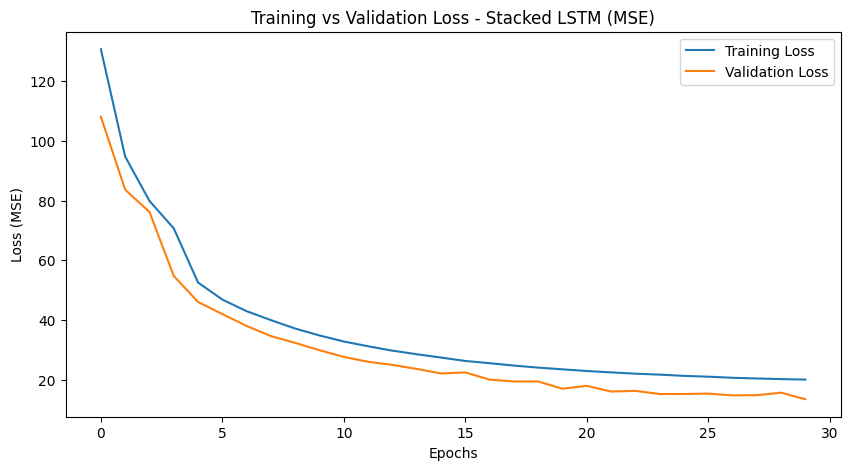

In [ ]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Loss (MSE)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss - Stacked LSTM (MSE)")
plt.legend()
plt.show()
